In [2]:
# CNN için veri hazırlığı
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

PROJECT_DIR = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (128, 128)   # CNN'e girecek görsel boyutu
BATCH_SIZE = 32

# Görselleri otomatik etiketleyen ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,        # pikselleri normalize ettim
    rotation_range=10,     # küçük dönüşler
    zoom_range=0.1,        # yakınlaştırma
    horizontal_flip=True,  # yatay çevirme
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\n Veri jeneratörleri hazır!")
print("Sınıflar:", train_generator.class_indices)


Found 4096 images belonging to 2 classes.
Found 1025 images belonging to 2 classes.

 Veri jeneratörleri hazır!
Sınıflar: {'Alzheimer': 0, 'Not_Alzheimer': 1}


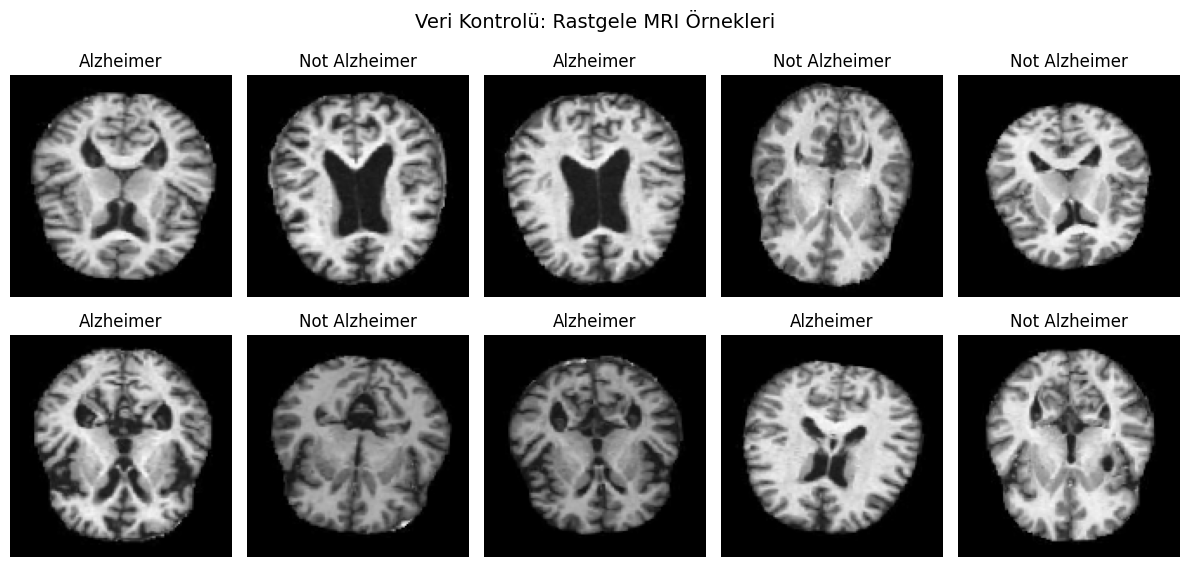

In [3]:
# Örnek MRI görsellerini görselleştirme (batch üzerinden)
import matplotlib.pyplot as plt
import numpy as np

# Bir batch al (örneğin 32 görsel)
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    label_text = "Alzheimer" if labels[i] == 0 else "Not Alzheimer"
    plt.title(label_text)
    plt.axis("off")

plt.suptitle("Veri Kontrolü: Rastgele MRI Örnekleri", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
#  Geliştirilmiş CNN modeli (grayscale + augmentation + derin yapı) 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

# Veri yolları 
PROJECT_DIR = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

#  Veri çoğaltma (augmentation)
# Modelin farklı açılardan, aydınlıklardan da öğrenmesini sağlar.
train_datagen = ImageDataGenerator(
    rescale=1./255,           # piksel değerlerini [0,1] aralığına çeker
    rotation_range=15,        # görüntüyü 15 derece döndürebilir
    zoom_range=0.2,           # %20 oranında yakınlaştırma/uzaklaştırma
    width_shift_range=0.1,    # yatayda %10 kaydırma
    height_shift_range=0.1,   # dikeyde %10 kaydırma
    shear_range=0.1,          # kesme (shear) dönüşümü
    horizontal_flip=True      # yatay çevirme (simetri)
)

test_datagen = ImageDataGenerator(rescale=1./255)

#  Görselleri yükle (grayscale) 
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',   #  MRI'lar siyah-beyaz, 1 kanal
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',   # test verisi de aynı
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# CNN Modeli 
model = Sequential([
    # İlk katman — küçük kenar ve doku farklarını öğrenir
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # İkinci katman — daha karmaşık şekilleri öğrenir
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Üçüncü katman — daha soyut beyin dokusu özellikleri
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Dördüncü katman — en yüksek seviyeli özellikleri yakalar
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Fully connected katmanlar
    Flatten(),
    Dense(256, activation='relu'),  # beyin dokularının birleşimini öğrenir
    Dropout(0.5),                   # overfitting'i azaltır
    Dense(1, activation='sigmoid')  # 0 = Alzheimer, 1 = Not Alzheimer
])

#  Model derleme 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#  Early stopping 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Eğitimi başlat 
EPOCHS = 25
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)


Found 4096 images belonging to 2 classes.
Found 1025 images belonging to 2 classes.
Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.5244 - loss: 10.9983 - val_accuracy: 0.4995 - val_loss: 10.9269
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5859 - loss: 7.9263 - val_accuracy: 0.4995 - val_loss: 15.1529
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5552 - loss: 5.9412 - val_accuracy: 0.4995 - val_loss: 12.7482
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5698 - loss: 4.0489 - val_accuracy: 0.5015 - val_loss: 7.1146
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5791 - loss: 2.6315 - val_accuracy: 0.5493 - val_loss: 3.0874
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5908 - loss: 1.5509 - val_accuracy: 0.6937 - val_loss: 0.6604
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5955 - loss: 0.9357 - val_accuracy: 0.6829 - val_loss: 0.5983
Epoch 8/